## This notebook will guide you step by step to build a modular, object-oriented AI Travel Agent system for trip planning with real-time data.

**Features:**
- Real-time weather information
- Top attractions, restaurants, activities, transportation
- Hotel cost estimation
- Currency conversion
- Complete itinerary generation
- Total expense calculation
- Trip summary

# API Choices for This Assignment

- Weather: OpenWeatherMap
- Hotels: Amadeus API
- Currency: ExchangeRate-API
- Attractions/Restaurants: Google Places API
- LLM: OpenAI


In [140]:
import os
from datetime import datetime
import pandas as pd
import requests
from langchain_community.utilities import GooglePlacesAPIWrapper, SerpAPIWrapper
from langchain_google_community import GooglePlacesTool
from forex_python.converter import CurrencyRates
from langgraph.graph import MessagesState, StateGraph, END, START
import matplotlib.pyplot as plt
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool
from langchain.chat_models import ChatOpenAI


In [141]:
from dotenv import load_dotenv
load_dotenv()

## Access API Keys


True

  ### Configuration Class

In [142]:
class Config:
    def __init__(self):
        self.openai_api_key = os.getenv('OPENAI_API_KEY')
        self.openweather_api_key = os.getenv('OPENWEATHER_API_KEY')
        self.exchange_rate_api_key = os.getenv('EXCHANGE_RATE_API_KEY')
        self.google_places_api_key = os.getenv('GPLACES_API_KEY')
        self.serpapi_key = os.getenv('SERPAPI_KEY')
        self.serper_api_key = os.getenv('SERPER_API_KEY')


### Service Classes

In [143]:
## Define weather Service Class
import requests

class WeatherService:
    def __init__(self, api_key):
        self.api_key = api_key

    def get_current_weather(self, city):
        url = "https://api.openweathermap.org/data/2.5/weather"
        params = {
            "q": city,
            "appid": self.api_key,
            "units": "metric"
        }
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            weather = {
                "city": city,
                "temperature": data["main"]["temp"],
                "description": data["weather"][0]["description"],
                "humidity": data["main"]["humidity"],
                "wind_speed": data["wind"]["speed"]
            }
            return weather
        else:
            return {"error": f"Failed to get weather for {city}: {response.text}"}
        
    def get_forecast(self, city, days=3):
        url = "https://api.openweathermap.org/data/2.5/forecast"
        params = {
        "q": city,
        "appid": self.api_key,
        "units": "metric"
        }
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
        # The forecast API returns data in 3-hour intervals for 5 days
        # You can process this to get daily summaries
            forecasts = []
            for entry in data["list"]:
                forecast = {
                "datetime": entry["dt_txt"],
                "temperature": entry["main"]["temp"],
                "description": entry["weather"][0]["description"]
             }
            forecasts.append(forecast)
            return forecasts[:days*8]  # 8 intervals per day
        else:
            return {"error": f"Failed to get forecast for {city}: {response.text}"}

In [144]:
from forex_python.converter import CurrencyRates
class CurrencyService:
    def __init__(self, api_key):
        self.api_key = api_key

    def get_exchange_rate(self, from_currency, to_currency):
        url = f"https://v6.exchangerate-api.com/v6/{self.api_key}/latest/{from_currency}"
        response = requests.get(url)
        data = response.json()
        if data["result"] == "success":
            return data["conversion_rates"].get(to_currency)
        return None

    def convert_currency(self, amount, from_currency, to_currency):
        rate = self.get_exchange_rate(from_currency, to_currency)
        if rate:
            return amount * rate
        return None

In [145]:
class ExpenseCalculator:
    def calculate_total_cost(self, hotel_cost, attraction_cost, food_cost, transport_cost, misc_cost):
        """
        Calculate the total trip cost by summing all provided costs.
        """
        try:
            return sum([
                float(hotel_cost or 0),
                float(attraction_cost or 0),
                float(food_cost or 0),
                float(transport_cost or 0),
                float(misc_cost or 0)
            ])
        except Exception as e:
            return f"Error calculating total cost: {e}"

    def calculate_daily_budget(self, total_cost, days):
        """
        Calculate the daily budget given total cost and number of days.
        """
        try:
            days = int(days)
            if days <= 0:
                return 0
            return float(total_cost) / days
        except Exception as e:
            return f"Error calculating daily budget: {e}"

In [146]:
class ItineraryService:
    def create_day_plan(self, city, attractions, weather):
        """
        Create a plan for a single day.
        """
        return {
            "city": city,
            "attractions": attractions,
            "weather": weather
        }

    def create_full_itinerary(self, days, day_plans):
        """
        Combine day plans into a full itinerary.
        """
        itinerary = []
        for i in range(int(days)):
            if i < len(day_plans):
                itinerary.append(day_plans[i])
            else:
                itinerary.append({"day": i+1, "note": "No plan available"})
        return itinerary

In [147]:
class SummaryService:
    def generate_summary(self, all_data):
        """
        Generate a summary of the trip.
        """
        summary = "Trip Summary:\n"
        if isinstance(all_data, dict):
            for key, value in all_data.items():
                summary += f"{key}: {value}\n"
        else:
            summary += str(all_data)
        return summary

In [148]:
# --- Tool Functions ---


@tool
def search_attractions(city: str):
    """Search for top attractions in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"tourist attractions in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"top attractions in {city}")


@tool
def search_restaurants(city: str):
    """Search for restaurants in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"restaurants in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"best restaurants in {city}")


@tool
def search_activities(city: str):
    """Search for activities in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"activities in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"things to do in {city}")


@tool
def search_transportation(city: str):
    """Search for transportation options in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"transportation in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"public transport in {city}")


@tool
def search_hotels(city: str, budget: str = "mid-range"):
    """Search for hotels in a city using Google Places, fallback to SerpAPI."""
    try:
        result = places_tool.run(f"{budget} hotels in {city}")
        if result and len(result) > 0:
            return result
    except Exception:
        pass
    return serpapi_wrapper.run(f"{budget} hotels in {city}")

# --- Weather Tools ---


@tool
def get_current_weather(city: str):
    """Get current weather for a city."""
    return weather_service.get_current_weather(city)


@tool
def get_forecast(city: str, days: int = 3):
    """Get weather forecast for a city."""
    return weather_service.get_forecast(city, days)

# --- Hotel Cost Tool ---


@tool
def estimate_hotel_cost(price_per_night: float, total_nights: int):
    """Estimate the total cost for a hotel stay."""
    return price_per_night * total_nights

# --- Currency Tools ---


@tool
def get_exchange_rate(from_currency: str, to_currency: str):
    """Get exchange rate between two currencies."""
    return currency_service.get_exchange_rate(from_currency, to_currency)


@tool
def convert_currency(amount: float, from_currency: str, to_currency: str):
    """Convert amount from one currency to another."""
    return currency_service.convert_currency(amount, from_currency, to_currency)

# --- Expense Tools ---


@tool
def calculate_total_cost(hotel_cost, attraction_cost, food_cost, transport_cost, misc_cost):
    """Calculate the total trip cost."""
    return expense_service.calculate_total_cost(hotel_cost, attraction_cost, food_cost, transport_cost, misc_cost)


@tool
def calculate_daily_budget(total_cost, days):
    """Calculate daily budget."""
    return expense_service.calculate_daily_budget(total_cost, days)

# --- Itinerary Tools ---


@tool
def create_day_plan(city, attractions, weather):
    """Create a plan for a single day."""
    return itinerary_service.create_day_plan(city, attractions, weather)


@tool
def create_full_itinerary(days, day_plans):
    """Combine day plans into a full itinerary."""
    return itinerary_service.create_full_itinerary(days, day_plans)

# --- Summary Tool ---


@tool
def generate_summary(all_data):
    """Generate a summary of the trip."""
    return summary_service.generate_summary(all_data)


# --- Bind all tools to the LLM ---
tools = [
    get_current_weather, get_forecast,
    search_attractions, search_restaurants, search_activities, search_transportation,
    search_hotels, estimate_hotel_cost,
    get_exchange_rate, convert_currency,
    calculate_total_cost, calculate_daily_budget,
    create_day_plan, create_full_itinerary,
    generate_summary
]

In [149]:
class TravelAgent:
    def __init__(self, config):
        self.weather = WeatherService(config.openweather_api_key)
        self.attractions = AttractionService(config.google_places_api_key, config.serpapi_key)
        self.hotels = HotelService(config.google_places_api_key, config.serpapi_key)
        self.currency = CurrencyService(config.exchange_rate_api_key)
        self.expense = ExpenseCalculator()
        self.itinerary = ItineraryService()
        self.summary = SummaryService()

    def plan_trip(self, city, days, budget, currency="USD"):
        # 1. Get weather
        weather = self.weather.get_forecast(city, days)
        # 2. Get attractions
        attractions = self.attractions.search_attractions(city)
        # 3. Get hotels
        hotels = self.hotels.search_hotels(city, budget)
        # 4. Estimate hotel cost (example: use first hotel, dummy price)
        price_per_night = 100  # You could extract this from hotel data if available
        hotel_cost = self.hotels.estimate_cost(price_per_night, days)
        # 5. Currency conversion (if needed)
        # 6. Calculate total expense (dummy values for now)
        total_cost = self.expense.calculate_total_cost(hotel_cost, 100, 100, 50, 50)
        daily_budget = self.expense.calculate_daily_budget(total_cost, days)
        # 7. Create itinerary
        itinerary = self.itinerary.create_full_itinerary(days, [
            self.itinerary.create_day_plan(city, attractions, weather)
            for _ in range(days)
        ])
        # 8. Generate summary
        summary = self.summary.generate_summary({
            "city": city,
            "days": days,
            "budget": budget,
            "total_cost": total_cost,
            "daily_budget": daily_budget,
            "itinerary": itinerary
        })
        return summary

### Create a Config Instance

In [150]:
config=Config()



In [151]:
# Use the config Object
weather_service = WeatherService(config.openweather_api_key)
currency_service = CurrencyService(config.exchange_rate_api_key)
expense_service = ExpenseCalculator()
itinerary_service = ItineraryService()
summary_service = SummaryService()
places_tool = GooglePlacesTool(gplaces_api_key=config.google_places_api_key)
serpapi_wrapper = SerpAPIWrapper(serpapi_api_key=config.serpapi_key)

### LLM and Agent Initialization

In [152]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo-16k",
    openai_api_key=config.openai_api_key,
    temperature=0
)

print("LLM Initialized Successfully!")

from langchain.agents import initialize_agent, AgentType

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.OPENAI_FUNCTIONS,  # or another agent type as appropriate
    verbose=True
)
from langchain.memory import ConversationBufferWindowMemory
memory = ConversationBufferWindowMemory(k=5)

from langchain.agents import initialize_agent, AgentType
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    memory=memory,
)

LLM Initialized Successfully!


### Agent Demo

In [153]:
prompt = ("""
       I want to visit Rome for 4 days with a focus on history, art, and food.
My budget is 800 EUR. Please provide:
- Weather forecast
- Must-see historical sites and museums
- Best local restaurants for Italian cuisine
- Hotel options near major attractions
- A day-by-day itinerary
- Estimated daily and total costs in EUR
- Tips for getting around the city
- Present the summary in a clear, organized format.
"""
   )
response = agent.invoke({"input": prompt})
print(response)

{'input': '\n       I want to visit Rome for 4 days with a focus on history, art, and food.\nMy budget is 800 EUR. Please provide:\n- Weather forecast\n- Must-see historical sites and museums\n- Best local restaurants for Italian cuisine\n- Hotel options near major attractions\n- A day-by-day itinerary\n- Estimated daily and total costs in EUR\n- Tips for getting around the city\n- Present the summary in a clear, organized format.\n', 'history': '', 'output': '### Trip Summary:\n- **Weather:** Clear sky with a temperature of 31.91°C\n- **Attractions:** Roman Forum, Trevi Fountain, Pantheon, Piazza del Popolo, Le Domus Romane di Palazzo Valentini, Spanish Steps, Colosseum, Domus Aurea, Baths of Caracalla, Capitoline Museums\n- **Restaurants:** Tonnarello | Paglia, Pane e Salame, Cantina e Cucina, Mercato Centrale, Nannarella, Nerone, Taverna dei migliori, Ambrosia Rooftop Restaurant & Bar, La locanda del tempio, Osteria da Fortunata\n- **Hotels:** Otivm Hotel, Salotto Monti, Hotel Corti

## Workflow Graph: LangGraph Orchestration

In [154]:
# --- Comprehensive LangGraph Workflow with Visualization ---
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END

# --- Nodes ---
def weather_node(state):
    city = state.get("city")
    days = state.get("days", 3)
    weather = weather_service.get_forecast(city, days)
    state["weather"] = weather
    return state

def attractions_node(state):
    city = state.get("city")
    try:
        result = places_tool.run(f"tourist attractions in {city}")
        if result and len(result) > 0:
            state["attractions"] = result
            state["use_fallback"] = False
        else:
             result = serpapi_wrapper.run(f"top attractions in {city}")
             state["attractions"] = result
    except Exception:
        raise Exception("Empty")
        state["use_fallback"] = True
    return state
            
def hotels_node(state):
    city = state.get("city")
    budget = state.get("budget", "mid-range")
    try:
        result = places_tool.run(f"{budget} hotels in {city}")
        if result and len(result) > 0:
            state["hotels"] = result
            state["use_hotels_fallback"] = False
        else:
            raise Exception("No hotels found")
    except Exception:
        fallback = serpapi_wrapper.run(f"{budget} hotels in {city}")
        state["hotels"] = fallback
        state["use_hotels_fallback"] = True
    return state

def itinerary_node(state):
    city = state.get("city")
    days = state.get("days", 3)
    attractions = state.get("attractions")
    weather = state.get("weather")
    day_plans = [
        itinerary_service.create_day_plan(city, attractions, weather)
        for _ in range(days)
    ]
    itinerary = itinerary_service.create_full_itinerary(days, day_plans)
    state["itinerary"] = itinerary
    return state

def summary_node(state):
    summary = {
        "city": state.get("city"),
        "days": state.get("days"),
        "weather": state.get("weather"),
        "attractions": state.get("attractions"),
        "hotels": state.get("hotels"),
        "itinerary": state.get("itinerary"),
        "total_cost": state.get("total_cost"),
        "daily_budget": state.get("daily_budget"),
        "attractions_fallback_used": state.get("use_attractions_fallback", False),
        "hotels_fallback_used": state.get("use_hotels_fallback", False)
    }
    state["summary"] = summary
    return state

# --- Graph Build ---
graph = StateGraph(dict)

# Add nodes
graph.add_node("weather", weather_node)
graph.add_node("attractions", attractions_node)

graph.add_node("hotels", hotels_node)
graph.add_node("itinerary", itinerary_node)
graph.add_node("summary", summary_node)

# Add edges
graph.add_edge(START, "weather")
graph.add_edge("weather", "attractions")

graph.add_edge("attractions", "hotels")
graph.add_edge("hotels", "itinerary")
graph.add_edge("itinerary", "summary")
graph.add_edge("summary", END)

# Compile
workflow = graph.compile()


In [155]:
workflow = graph.compile()


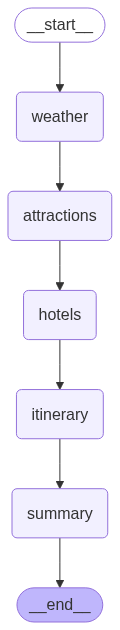

In [156]:
from IPython.display import display, Image
display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))


In [157]:
result = workflow.invoke(initial_state)
print("=== Final State ===")
print(result)
print("=== Trip Summary ===")
print(result.get("summary"))

=== Final State ===
{'city': 'Rome', 'days': 3, 'budget': 'mid-range', 'currency': 'EUR', 'weather': [{'datetime': '2025-06-25 15:00:00', 'temperature': 31.91, 'description': 'clear sky'}], 'attractions': '1. Roman Forum\nAddress: 00186 Rome, Metropolitan City of Rome Capital, Italy\nGoogle place ID: ChIJ782pg7NhLxMR5n3swAdAkfo\nPhone: 06 2111 5843\nWebsite: https://colosseo.it/area/foro-romano/\n\n\n2. Trevi Fountain\nAddress: Piazza di Trevi, 00187 Roma RM, Italy\nGoogle place ID: ChIJ1UCDJ1NgLxMRtrsCzOHxdvY\nPhone: 06 0608\nWebsite: https://www.turismoroma.it/it/luoghi/fontana-di-trevi\n\n\n3. Pantheon\nAddress: Piazza della Rotonda, 00186 Roma RM, Italy\nGoogle place ID: ChIJqUCGZ09gLxMRLM42IPpl0co\nPhone: 06 6830 0230\nWebsite: https://direzionemuseiroma.cultura.gov.it/pantheon/\n\n\n4. Piazza del Popolo\nAddress: Piazza del Popolo, 00187 Roma RM, Italy\nGoogle place ID: ChIJhxbo5fhgLxMRUEPO_f-f7kM\nPhone: Unknown\nWebsite: https://www.turismoroma.it/it/node/1517\n\n\n5. Le Domus 